# Targeting high value customers based on customer demographics and attributes.
> This project was done under the umbrella of KPMG internship experience. I was provided data sets of an organization targeting a client who wants a feedback from us on their dataset quality and how this can be improved.

### Background
- Sprocket Central Pty Ltd, a medium size bikes & cycling accessories organisation
- needs help with its customer and transactions data
- how to analyse it to help optimise its marketing strategy effectively.

### Datasets
- New Customer List
- Customer Demographic
- Customer Addresses
- Transactions data in the past 3 months


### Task
- Exploratory Data Analysis to understand the data and its quality
- Model building to predict the high value customers
- Results and recommendations

In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import datetime as dt

In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importing data
xls = pd.ExcelFile('KPMG_VI_New_raw_data_update_final.xlsx')

Transactions = pd.read_excel(xls, 'Transactions', skiprows=1)
NewCustomerList = pd.read_excel(xls, 'NewCustomerList', skiprows=1)
Demographic = pd.read_excel(xls, 'CustomerDemographic', skiprows=1)
Address = pd.read_excel(xls, 'CustomerAddress', skiprows=1)

### Checking correlation and common columns among the sheets

In [4]:
# Making variables to store the columns of each dataframe

transactions_columns = Transactions.columns
demographic_columns = Demographic.columns
newcustomerlist_columns = NewCustomerList.columns
address_columns = Address.columns

transactions_columns.name = 'transactions_columns'
demographic_columns.name = 'demographic_columns'
newcustomerlist_columns.name = 'newcustomerlist_columns'
address_columns.name = 'address_columns'

In [5]:
# A code I prompted to generate a dataframe to generate a sheet vs column presence table
# This shows if a column header is present across multiple dataframes or not

def column_comparison_table(*columns):
    """
    Generate a DataFrame to show the presence of attributes in each column.

    Args:
        *columns: Variable number of pandas DataFrame columns.

    Returns:
        A pandas DataFrame with the presence of attributes in each column.
        The column headers are based on the names of the passed columns,
        or generic names if the columns don't have names.
        The displayed columns are in the same order of the passed column arguments.
        The DataFrame is sorted based on the number of '1' values horizontally (across the rows).

    """
    # Step 1: Convert the column(s) to set(s)
    column_sets = [set(col) for col in columns]

    # Step 2: Create a set of all unique attributes from the column(s)
    all_attributes = sorted(list(set().union(*column_sets)))

    # Step 3: Create a dictionary to store the presence of attributes in each column
    presence_dict = {'Attributes': all_attributes}
    for i, col in enumerate(columns):
        column_name = col.name if col.name else f'Column {i+1}'
        presence_dict[column_name] = [1 if attr in col else 0 for attr in all_attributes]

    # Step 4: Create a DataFrame from the presence dictionary
    presence_df = pd.DataFrame(presence_dict)

    # Step 5: Sort the dataframe based on the number of '1' values horizontally (across the rows)
    presence_df = presence_df.iloc[presence_df.iloc[:, 1:].sum(axis=1).sort_values(ascending=False).index]

    # Reset the index
    presence_df = presence_df.reset_index(drop=True)

    return presence_df


In [6]:
columns_presence_df = column_comparison_table(transactions_columns, demographic_columns, address_columns,newcustomerlist_columns)
columns_presence_df

Attributes  transactions_columns  \
0                           customer_id                     1   
1                                   DOB                     0   
2                            first_name                     0   
3                                tenure                     0   
4                                 state                     0   
5                    property_valuation                     0   
6                              postcode                     0   
7   past_3_years_bike_related_purchases                     0   
8                              owns_car                     0   
9                             job_title                     0   
10                job_industry_category                     0   
11                               gender                     0   
12                            last_name                     0   
13                       wealth_segment                     0   
14                              country                     0   
15                              address                     0   
16                   deceased_indicator                     0   
17                           product_id                     1   
18                       transaction_id                     1   
19                     transaction_date                     1   
20                          Unnamed: 16                     0   
21                          Unnamed: 17                     0   
22                        standard_cost                     1   
23                          Unnamed: 18                     0   
24                         product_size                     1   
25                         product_line                     1   
26                              default                     0   
27              product_first_sold_date                     1   
28                          Unnamed: 19                     0   
29                          Unnamed: 20                     0   
30                                Value                     0   
31                         order_status                     1   
32                         online_order                     1   
33                           list_price                     1   
34                                 Rank                     0   
35                                brand                     1   
36                        product_class                     1   

    demographic_columns  address_columns  newcustomerlist_columns  
0                     1                1                        0  
1                     1                0                        1  
2                     1                0                        1  
3                     1                0                        1  
4                     0                1                        1  
5                     0                1                        1  
6                     0                1                        1  
7                     1                0                        1  
8                     1                0                        1  
9                     1                0                        1  
10                    1                0                        1  
11                    1                0                        1  
12                    1                0                        1  
13                    1                0                        1  
14                    0                1                        1  
15                    0                1                        1  
16                    1                0                        1  
17                    0                0                        0  
18                    0                0                        0  
19                    0                0                        0  
20                    0                0                        1  
21                    0                0                      

### Highlights of the corelation analysis
We are supposed to combine the data from the three sheets (Customer Demographic, Customer Addresses, Transactions) and then make a Master Sheet which would be a training set where we would train our model to predict the high value customers.
- can use **customer_id** as the primary key to combine the data
- there are some irrelevant columns in plain sight which can be dropped
- there are rows with missing data which can be dropped as well, since it would affect the model building
- the DOB can be converted to age, and then we can perform an analysis with different age groups
- a **polynomial regression** model can be used to predict the high value customers
- values for the states, DOB and gender can be made uniform.

## Building a master Dataframe to train the model
- The master dataframe is built by combining the three sheets using the customer_id as the primary key
- The irrelevant columns are dropped
- reference for [pandas merge](https://www.youtube.com/watch?v=h4hOPGo4UVU)

In [7]:
# Merging the dataframes using customer_id as the key
merged_df = pd.merge(Demographic, Address, on='customer_id', how='outer')
master_df = pd.merge(merged_df, Transactions, on='customer_id', how='outer')
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20510 entries, 0 to 20509
Data columns (total 30 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          20510 non-null  int64         
 1   first_name                           20504 non-null  object        
 2   last_name                            19849 non-null  object        
 3   gender                               20504 non-null  object        
 4   past_3_years_bike_related_purchases  20504 non-null  float64       
 5   DOB                                  20047 non-null  object        
 6   job_title                            18027 non-null  object        
 7   job_industry_category                17180 non-null  object        
 8   wealth_segment                       20504 non-null  object        
 9   deceased_indicator                   20504 non-null  object        
 10  default   

In [8]:
# List of columns to drop
columns_to_drop = ['transaction_id', 'product_id', 'first_name', 'last_name', 'default', 'country','address', 'deceased_indicator']
# Create a new DataFrame by dropping the specified columns
master_stripped = master_df.drop(columns=columns_to_drop)
master_stripped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20510 entries, 0 to 20509
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          20510 non-null  int64         
 1   gender                               20504 non-null  object        
 2   past_3_years_bike_related_purchases  20504 non-null  float64       
 3   DOB                                  20047 non-null  object        
 4   job_title                            18027 non-null  object        
 5   job_industry_category                17180 non-null  object        
 6   wealth_segment                       20504 non-null  object        
 7   owns_car                             20504 non-null  object        
 8   tenure                               20047 non-null  float64       
 9   postcode                             20478 non-null  float64       
 10  state     

### Making the dates uniform and adding the age column

In [9]:
# Making the DOB and transaction_date columns into datetime objects
master_stripped['DOB'] = pd.to_datetime(master_stripped['DOB'])
master_stripped['transaction_date'] = pd.to_datetime(master_stripped['transaction_date'])

In [10]:
# Define the start and end dates of the dataset
start_date = pd.to_datetime('2017-01-01')
end_date = pd.to_datetime('2017-12-31')

# Convert "DOB" column to datetime format
master_stripped['DOB'] = pd.to_datetime(master_stripped['DOB'])

# Calculate customer age based on "DOB" column
master_stripped['customer_age'] = ((end_date - master_stripped['DOB']).dt.days // 365.25)


In [11]:
# Fix the Product First sold date and add a product age column
master_stripped['product_first_sold_date'] = pd.to_timedelta(master_stripped['product_first_sold_date'], unit='D') + pd.Timestamp('1900-01-01')
today_date = pd.Timestamp('2018-01-01')
date_difference = pd.Timestamp.today() - today_date

master_stripped['product_first_sold_date'] = master_stripped['product_first_sold_date'] - date_difference

master_stripped['product_age'] = ((today_date - master_stripped['product_first_sold_date']).dt.days // 365.25)

In [12]:
master_stripped.head()

customer_id gender  past_3_years_bike_related_purchases        DOB  \
0            1      F                                 93.0 1953-10-12   
1            1      F                                 93.0 1953-10-12   
2            1      F                                 93.0 1953-10-12   
3            1      F                                 93.0 1953-10-12   
4            1      F                                 93.0 1953-10-12   

             job_title job_industry_category wealth_segment owns_car  tenure  \
0  Executive Secretary                Health  Mass Customer      Yes    11.0   
1  Executive Secretary                Health  Mass Customer      Yes    11.0   
2  Executive Secretary                Health  Mass Customer      Yes    11.0   
3  Executive Secretary                Health  Mass Customer      Yes    11.0   
4  Executive Secretary                Health  Mass Customer      Yes    11.0   

   postcode  ... order_status           brand product_line  product_class  \
0    2016.0  ...     Approved      OHM Cycles     Standard         medium   
1    2016.0  ...     Approved           Solex     Standard         medium   
2    2016.0  ...     Approved   Trek Bicycles         Road            low   
3    2016.0  ...     Approved  Norco Bicycles     Standard         medium   
4    2016.0  ...     Approved           Solex     Standard         medium   

  product_size list_price standard_cost    product_first_sold_date  \
0       medium     235.63        125.07 1999-07-24 04:51:00.786764   
1       medium    1577.53        826.51 2002-06-02 04:51:00.786764   
2        small    1720.70       1531.42 1997-10-03 04:51:00.786764   
3       medium     360.40        270.30 1997-11-22 04:51:00.786764   
4       medium      71.49         53.62 1999-10-23 04:51:00.786764   

  customer_age  product_age  
0         64.0         18.0  
1         64.0         15.0  
2         64.0         20.0  
3         64.0         20.0  
4         64.0         18.0  

[5 rows x 24 columns]

### Making the States and Genders uniform

In [13]:
# Replace 'New South Wales' with 'NSW' and Victoria with 'VIC'
master_stripped['state'] = master_stripped['state'].replace('New South Wales', 'NSW')
master_stripped['state'] = master_stripped['state'].replace('Victoria', 'VIC')

# Replace 'Female'and 'Femal' with 'F' and 'Male' with 'M'
master_stripped['gender'] = master_stripped['gender'].replace('Female', 'F')
master_stripped['gender'] = master_stripped['gender'].replace('Femal', 'F')
master_stripped['gender'] = master_stripped['gender'].replace('Male', 'M')

# Replace 'U' with np.nan
master_stripped['gender'] = master_stripped['gender'].replace('U', np.nan)


In [14]:
# Obtain the unique values of the "state" and the gender columns
states = master_stripped['state'].unique()
genders = master_stripped['gender'].unique()

In [15]:
print(states)
print(genders)

['NSW' nan 'QLD' 'VIC']
['F' 'M' nan]


### Converting the non Boolean values to Boolean values

In [16]:
# Fixing the owns_car column

# Step 1: Replace blank values with NaN
master_stripped['owns_car'].replace('', pd.NA, inplace=True)

# Step 2: Convert 'Yes' to True and 'No' to False
mapping = {'Yes': True, 'No': False}
master_stripped['owns_car'] = master_stripped['owns_car'].map(mapping)

# Step 3: Fill NaN values with False
master_stripped['owns_car'].fillna(False, inplace=True)

In [17]:
# Fixing the owns_car column

# Step 1: Replace blank values with NaN
master_stripped['order_status'].replace('', pd.NA, inplace=True)

# Step 2: Convert 'Yes' to True and 'No' to False
mapping = {'Approved': True, 'Cancelled': False}
master_stripped['order_status'] = master_stripped['order_status'].map(mapping)

# Step 3: Fill NaN values with False
master_stripped['order_status'].fillna(False, inplace=True)

In [18]:
# Fixing the online_order column
# Step 1: Replace blank values with NaN
master_stripped['online_order'].replace('', pd.NA, inplace=True)

# Step 2: Convert the column to boolean type
master_stripped['online_order'] = master_stripped['online_order'].astype('boolean')

### Fixing bad floats

In [19]:
master_stripped['tenure'] = master_stripped['tenure'].astype('Int64')
master_stripped['past_3_years_bike_related_purchases'] = master_stripped['past_3_years_bike_related_purchases'].astype('Int64')
master_stripped['postcode'] = master_stripped['postcode'].astype('Int64')
master_stripped['property_valuation'] = master_stripped['property_valuation'].astype('Int64')
master_stripped['customer_age'] = master_stripped['customer_age'].astype('Int64')

In [20]:
master_stripped.to_csv('master_stripped.csv', index=False)

### Analysing Null Values of the Master Dataframe

In [21]:
# Function to analyse the missing data

def analyze_null_values(dataframe):
    total_null_values = dataframe.isnull().sum()
    total_values = dataframe.count().sort_values(ascending=True)
    null_values_percentage = (total_null_values / total_values) * 100
    missing_data = pd.concat(
        {'Null Values': total_null_values, 'Total Values': total_values, 'Percentage of Missing Values': null_values_percentage},
        axis=1
    )
    
    missing_data = missing_data.sort_values(by='Percentage of Missing Values', ascending=False)
    
    return missing_data


In [22]:
analyze_null_values(master_stripped)

Null Values  Total Values  \
job_industry_category                       3330         17180   
job_title                                   2483         18027   
online_order                                 870         19640   
product_age                                  707         19803   
product_first_sold_date                      707         19803   
standard_cost                                707         19803   
product_size                                 707         19803   
product_class                                707         19803   
product_line                                 707         19803   
brand                                        707         19803   
list_price                                   510         20000   
transaction_date                             510         20000   
gender                                       472         20038   
tenure                                       463         20047   
DOB                                          463         20047   
customer_age                                 463         20047   
property_valuation                            32         20478   
state                                         32         20478   
postcode                                      32         20478   
wealth_segment                                 6         20504   
past_3_years_bike_related_purchases            6         20504   
order_status                                   0         20510   
owns_car                                       0         20510   
customer_id                                    0         20510   

                                     Percentage of Missing Values  
job_industry_category                                   19.383003  
job_title                                               13.773784  
online_order                                             4.429735  
product_age                                              3.570166  
product_first_sold_date                                  3.570166  
standard_cost                                            3.570166  
product_size                                             3.570166  
product_class                                            3.570166  
product_line                                             3.570166  
brand                                                    3.570166  
list_price                                               2.550000  
transaction_date                                         2.550000  
gender                                                   2.355525  
tenure                                                   2.309573  
DOB                                                      2.309573  
customer_age                                             2.309573  
property_valuation                                       0.156265  
state                                                    0.156265  
postcode                                                 0.156265  
wealth_segment                                           0.029263  
past_3_years_bike_related_purchases                      0.029263  
order_status                                             0.000000  
owns_car                                                 0.000000  
customer_id                                              0.000000

In [23]:
# Make a copy of the DataFrame
master_null = master_stripped.copy()

# Fill missing values in 'job_industry_category' with the mode
mode_industry_category = master_null['job_industry_category'].mode()[0]
master_null['job_industry_category'].fillna(mode_industry_category, inplace=True)

# Fill missing values in 'job_title' with the mode
# mode_job_title = master_null['job_title'].mode()[0]
# master_null['job_title'].fillna(mode_job_title, inplace=True)
# Wasnt the bset idea to fill the missing values with the mode.

# Fill missing values in 'online_order' with the mode
mode_online_order = master_null['online_order'].mode()[0]
master_null['online_order'].fillna(mode_online_order, inplace=True)

# Drop rows with any remaining missing values
master_null.dropna(inplace=True)

analyze_null_values(master_null)

Null Values  Total Values  \
customer_id                                    0         17015   
gender                                         0         17015   
customer_age                                   0         17015   
product_first_sold_date                        0         17015   
standard_cost                                  0         17015   
list_price                                     0         17015   
product_size                                   0         17015   
product_class                                  0         17015   
product_line                                   0         17015   
brand                                          0         17015   
order_status                                   0         17015   
online_order                                   0         17015   
transaction_date                               0         17015   
property_valuation                             0         17015   
state                                          0         17015   
postcode                                       0         17015   
tenure                                         0         17015   
owns_car                                       0         17015   
wealth_segment                                 0         17015   
job_industry_category                          0         17015   
job_title                                      0         17015   
DOB                                            0         17015   
past_3_years_bike_related_purchases            0         17015   
product_age                                    0         17015   

                                     Percentage of Missing Values  
customer_id                                                   0.0  
gender                                                        0.0  
customer_age                                                  0.0  
product_first_sold_date                                       0.0  
standard_cost                                                 0.0  
list_price                                                    0.0  
product_size                                                  0.0  
product_class                                                 0.0  
product_line                                                  0.0  
brand                                                         0.0  
order_status                                                  0.0  
online_order                                                  0.0  
transaction_date                                              0.0  
property_valuation                                            0.0  
state                                                         0.0  
postcode                                                      0.0  
tenure                                                        0.0  
owns_car                                                      0.0  
wealth_segment                                                0.0  
job_industry_category                                         0.0  
job_title                                                     0.0  
DOB                                                           0.0  
past_3_years_bike_related_purchases                           0.0  
product_age                                                   0.0

### Highlights of the Null Values Analysis
- job_title and job_industry_category have a lot of null values
- we can make two models, one where the job_title and job_industry_category are dropped, and one where they are not dropped
- learn about RFM analysis and KDD method
- followed a tutorial, the guy dropped all the null values no questions asked.
- after I checked the bar plot of the null values, I decided to use mode for the missing job_title and job_industry_category

### Creating a profit column
This would be used for the M value in the RFM analysis

In [24]:
master_null['profit'] = master_null['list_price'] - master_null['standard_cost']
master_null.head()

customer_id gender  past_3_years_bike_related_purchases        DOB  \
0            1      F                                   93 1953-10-12   
1            1      F                                   93 1953-10-12   
2            1      F                                   93 1953-10-12   
3            1      F                                   93 1953-10-12   
4            1      F                                   93 1953-10-12   

             job_title job_industry_category wealth_segment  owns_car  tenure  \
0  Executive Secretary                Health  Mass Customer      True      11   
1  Executive Secretary                Health  Mass Customer      True      11   
2  Executive Secretary                Health  Mass Customer      True      11   
3  Executive Secretary                Health  Mass Customer      True      11   
4  Executive Secretary                Health  Mass Customer      True      11   

   postcode  ...           brand  product_line product_class  product_size  \
0      2016  ...      OHM Cycles      Standard        medium        medium   
1      2016  ...           Solex      Standard        medium        medium   
2      2016  ...   Trek Bicycles          Road           low         small   
3      2016  ...  Norco Bicycles      Standard        medium        medium   
4      2016  ...           Solex      Standard        medium        medium   

   list_price standard_cost    product_first_sold_date customer_age  \
0      235.63        125.07 1999-07-24 04:51:00.786764           64   
1     1577.53        826.51 2002-06-02 04:51:00.786764           64   
2     1720.70       1531.42 1997-10-03 04:51:00.786764           64   
3      360.40        270.30 1997-11-22 04:51:00.786764           64   
4       71.49         53.62 1999-10-23 04:51:00.786764           64   

  product_age  profit  
0        18.0  110.56  
1        15.0  751.02  
2        20.0  189.28  
3        20.0   90.10  
4        18.0   17.87  

[5 rows x 25 columns]

### Creating a Transaction Day, Week, Month Column

In [25]:
master_null['transaction_day'] = master_null['transaction_date'].dt.strftime('%A')
master_null['transaction_month'] = master_null['transaction_date'].dt.strftime('%B')

### Creating Age Groups

In [26]:
# Checking the min and max age of the customers
master_null['customer_age'].describe()

count      17015.0
mean     39.858654
std      12.558468
min           15.0
25%           30.0
50%           40.0
75%           49.0
max           86.0
Name: customer_age, dtype: Float64

In [27]:
# Making age groups starting from 15 to 86 with 20 years interval
age_group = pd.cut(master_null['customer_age'], bins = [14,30,50,70,90], labels= ['14-30','31-50','51-70','71-90'])
master_null['age_group'] = age_group

master_null.head(1)

customer_id gender  past_3_years_bike_related_purchases        DOB  \
0            1      F                                   93 1953-10-12   

             job_title job_industry_category wealth_segment  owns_car  tenure  \
0  Executive Secretary                Health  Mass Customer      True      11   

   postcode  ... product_size  list_price standard_cost  \
0      2016  ...       medium      235.63        125.07   

     product_first_sold_date  customer_age product_age  profit  \
0 1999-07-24 04:51:00.786764            64        18.0  110.56   

  transaction_day transaction_month  age_group  
0        Saturday          December      51-70  

[1 rows x 28 columns]

## Creating the RFM table

In [28]:
# We already have the Monetary value (profit) of each customer
# Preparing the Recency Value

master_null['recency'] = (today_date - master_null['transaction_date']).dt.days
master_null['frequency'] = master_null.groupby('customer_id')['customer_id'].transform('count')
master_null.head()

customer_id gender  past_3_years_bike_related_purchases        DOB  \
0            1      F                                   93 1953-10-12   
1            1      F                                   93 1953-10-12   
2            1      F                                   93 1953-10-12   
3            1      F                                   93 1953-10-12   
4            1      F                                   93 1953-10-12   

             job_title job_industry_category wealth_segment  owns_car  tenure  \
0  Executive Secretary                Health  Mass Customer      True      11   
1  Executive Secretary                Health  Mass Customer      True      11   
2  Executive Secretary                Health  Mass Customer      True      11   
3  Executive Secretary                Health  Mass Customer      True      11   
4  Executive Secretary                Health  Mass Customer      True      11   

   postcode  ... standard_cost    product_first_sold_date customer_age  \
0      2016  ...        125.07 1999-07-24 04:51:00.786764           64   
1      2016  ...        826.51 2002-06-02 04:51:00.786764           64   
2      2016  ...       1531.42 1997-10-03 04:51:00.786764           64   
3      2016  ...        270.30 1997-11-22 04:51:00.786764           64   
4      2016  ...         53.62 1999-10-23 04:51:00.786764           64   

   product_age  profit transaction_day transaction_month age_group recency  \
0         18.0  110.56        Saturday          December     51-70       9   
1         15.0  751.02        Thursday             April     51-70     270   
2         20.0  189.28        Thursday               May     51-70     235   
3         20.0   90.10        Thursday           January     51-70     361   
4         18.0   17.87         Tuesday          February     51-70     314   

   frequency  
0         11  
1         11  
2         11  
3         11  
4         11  

[5 rows x 30 columns]

Now that we have the RFM Values of each customer, we can make a new RFM Dataframe and use it to make clusters of the customers, and later use it to map to customer IDs and predict the high value customers.

In [29]:
rfm_table = master_null.groupby('customer_id').agg({'recency': lambda x: x.min(), 'frequency': lambda x: x.count(), 'profit': lambda x: x.sum()})
rfm_table.rename(columns={'recency': 'recency_value', 'frequency': 'frequency_value', 'profit': 'monetary_value'}, inplace=True)

### Using KMeans to make clusters
- Write a function to scale the features (use standard scaler)
- Write a function to fit the KMeans algorithm on the scaled features and return the model as well as the predictions
- Make sure to run this only on the clean rfm dataframe

In [30]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

def plot_elbow_method(df):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df)

    inertia = []
    for i in np.arange(1, 11):
        kmeans = KMeans(n_clusters=i, n_init=10, random_state=1) # n_init is the number of times the K-mean algorithm will run with different centroid seeds (default=10), explicityly set to 10 to suppress warning
        kmeans.fit(scaled)
        inertia.append(kmeans.inertia_)

    plt.plot(np.arange(1, 11), inertia, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.show()
    
    return scaled

# Example usage:
# Assuming you have a DataFrame called 'rfm_table', you can call the function like this:
# plot_elbow_method(rfm_table)

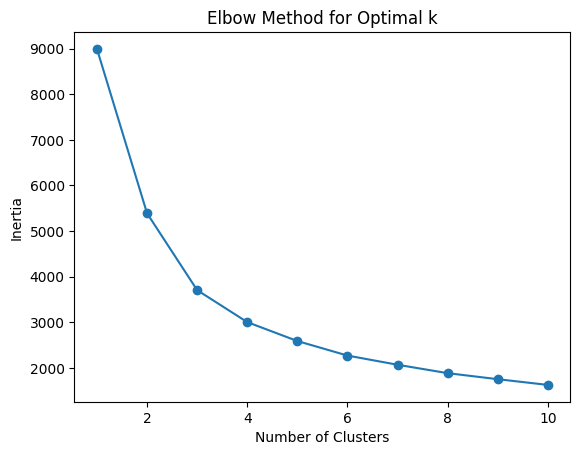

In [31]:
scaled_array = plot_elbow_method(rfm_table)

Seems like the optimal number of clusters is 3, we'll then classify each unique customer into one of these 3 clusters.

In [32]:
kmeans = KMeans(n_clusters=3, n_init=50, random_state=1)
kmeans.fit(scaled_array)

# +1 to make the clusters start from 1 instead of 0
rfm_table['cluster'] = kmeans.labels_+1
rfm_table

recency_value  frequency_value  monetary_value  cluster
customer_id                                                         
1                        9               11         3018.09        3
2                      130                3         2226.26        2
5                       18                6         2394.94        1
8                       24               10         7066.94        3
9                       80                6         2353.11        1
...                    ...              ...             ...      ...
3493                    95                6         3728.88        1
3494                     6                4         2755.11        1
3495                    15                7         3847.65        3
3496                   258                4         2045.84        2
3497                    54                3         1648.32        1

[2997 rows x 4 columns]

Now that we have the clusters, we will analyse the clusters and see which cluster has the highest profit, and then we will map the customer IDs to the clusters and then predict the high value customers.

In [33]:
cluster_map = rfm_table.groupby('cluster').agg({'recency_value': 'mean', 'frequency_value': 'mean', 'monetary_value': 'mean'})
cluster_map["cluster_size"] = rfm_table.groupby('cluster')['cluster'].count()

sorted_cluster_map = cluster_map.sort_values(by='monetary_value', ascending=False)
customer_category = ['Gold', 'Silver', 'Bronze']
sorted_cluster_map['customer_category'] = customer_category
# Create a mapping of clusters to categories
category_cluster = sorted_cluster_map['customer_category'].to_dict()

sorted_cluster_map
# category_cluster

recency_value  frequency_value  monetary_value  cluster_size  \
cluster                                                                 
3            40.938259         8.087045     5030.305152           988   
1            44.413430         4.781435     2323.693193          1519   
2           170.069388         3.595918     1845.393531           490   

        customer_category  
cluster                    
3                    Gold  
1                  Silver  
2                  Bronze

It's obvious that the cluster 3 customers are the high value customers, then cluster 1 and then cluster 2.

There are comparatively less customers in cluster 3, but they have the highest profit, given cluster two customers are the most in number but struggle to keep up with the profits of cluster 3 customers.

In [34]:
import plotly.express as px

# Create an interactive 3D scatter plot
fig = px.scatter_3d(
    rfm_table,
    x='recency_value',
    y='frequency_value',
    z='monetary_value',
    color='cluster',
    size_max=10,
    opacity=0.7,
    labels={'recency_value': 'Recency', 'frequency_value': 'Frequency', 'monetary_value': 'Monetary'},
    title='RFM Clusters - Interactive 3D Scatter Plot'
)

fig.show()

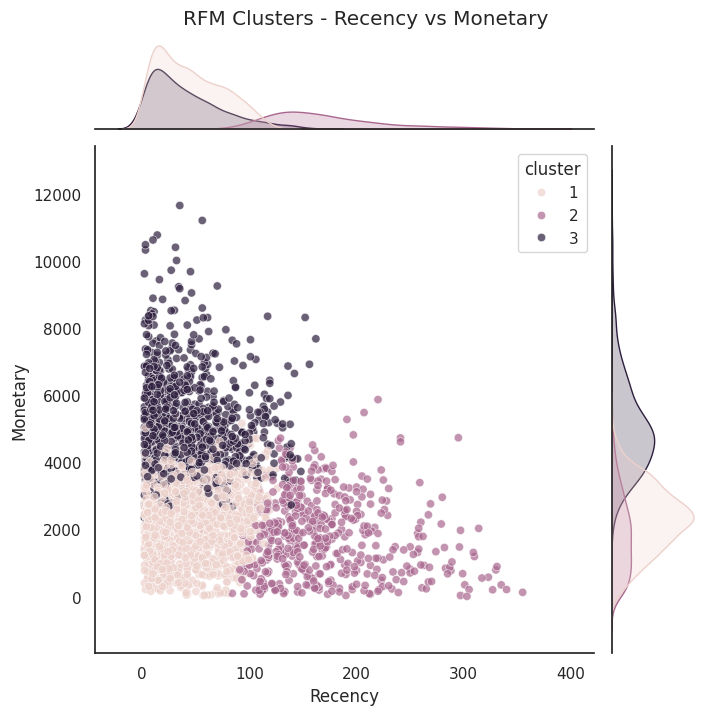

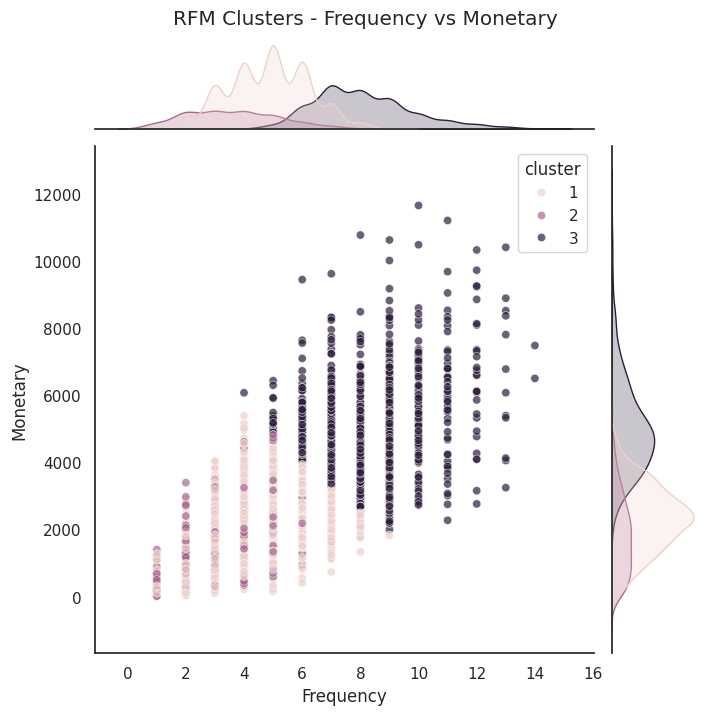

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a joint plot for 'recency_value' and 'monetary_value'
sns.set(style="white")
fig1 = sns.jointplot(
    data=rfm_table,
    x='recency_value',
    y='monetary_value',
    hue='cluster',
    alpha=0.7,
    markers=["o", "s", "D"],
    height=7
)
fig1.set_axis_labels('Recency', 'Monetary')
fig1.fig.suptitle('RFM Clusters - Recency vs Monetary', y=1.02)

# Create a joint plot for 'frequency_value' and 'monetary_value'
fig2 = sns.jointplot(
    data=rfm_table,
    x='frequency_value',
    y='monetary_value',
    hue='cluster',
    alpha=0.7,
    markers=["o", "s", "D"],
    height=7
)
fig2.set_axis_labels('Frequency', 'Monetary')
fig2.fig.suptitle('RFM Clusters - Frequency vs Monetary', y=1.02)

# Display the subplots
plt.show()


In [36]:
# Mapping the clusters to the customers
master_null['cluster'] = master_null['customer_id'].map(rfm_table['cluster'])
master_null['customer_category'] = master_null['cluster'].map(category_cluster)

### Predicting the high value customers
Now that we have the clusters, we will map the customer IDs to the clusters and then predict the high value customers.
To do this
- Our target is to check what demographic brings out the most cluster 1 type of customers
- We will use the customer demographic sheet for this, and make age groups and then check which age group has the most cluster 1 customers
- Similarly what job titles and job industries bring out the most cluster 1 customers
- And what city and state brings out the most cluster 1 customers
- And since we are doing this, we will make a graph for all the clusters and not just cluster 1

## Univariate Exploration
> We will investigate the distribution of individual variables like done on [Kaggle](https://www.kaggle.com/code/abdallahellawah/kpmg-internship-module-2)
> 
> If we find any outliers, we will take a deeper look to understand why they exist and how they affect the distribution.


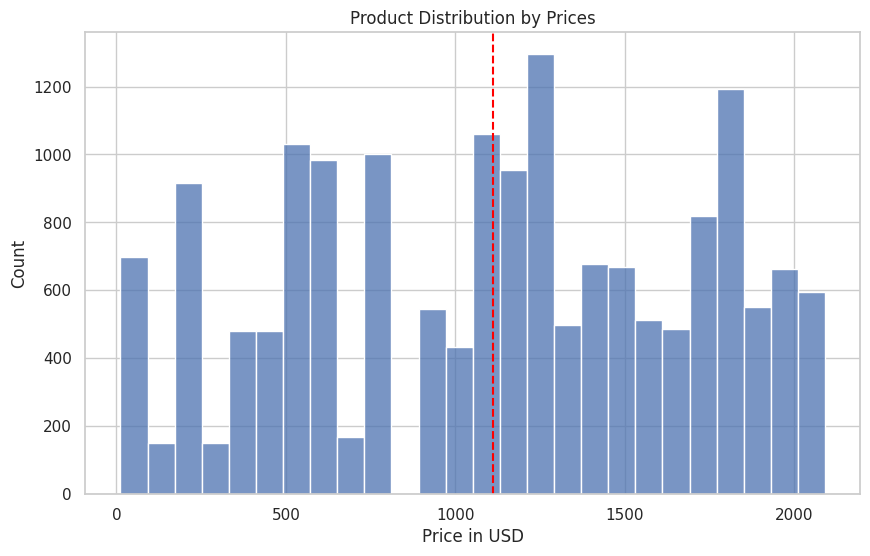

Mean:  1110.3377249485748


In [37]:
# Product Distribution by Prices

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

plt.figure(figsize=(10, 6))
sns.histplot(data=master_null, x='list_price')
plt.title('Product Distribution by Prices')
plt.xlabel('Price in USD')
plt.ylabel('Count')
plt.axvline(master_null['list_price'].mean(), color='red', linestyle='--', label='Mean')
plt.show()

print('Mean: ', master_null['list_price'].mean())

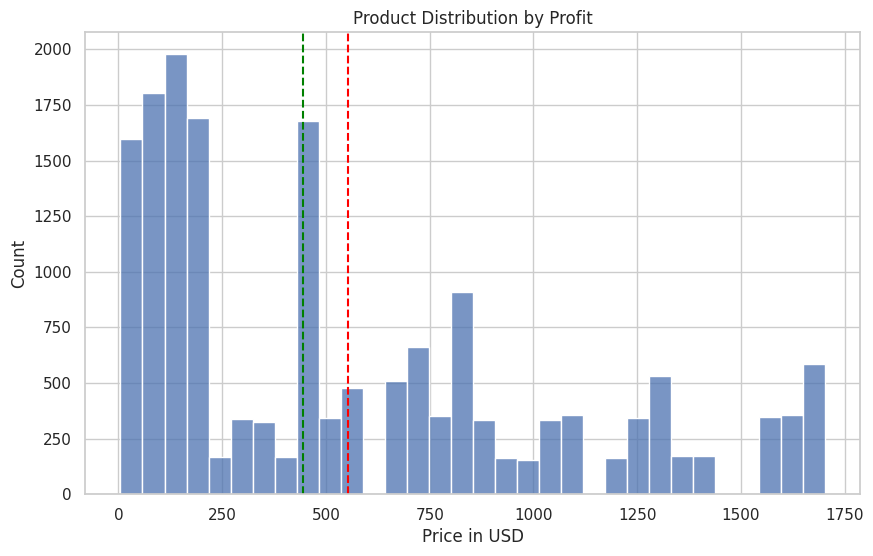

Mean:  552.6814152218631
Median:  445.2099999999999


In [38]:
# Product Distribution by Profit

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

plt.figure(figsize=(10, 6))
sns.histplot(data=master_null, x='profit')
plt.title('Product Distribution by Profit')
plt.xlabel('Price in USD')
plt.ylabel('Count')
plt.axvline(master_null['profit'].mean(), color='red', linestyle='--', label='Mean')
plt.axvline(master_null['profit'].median(), color='green', linestyle='--', label='Median')
plt.show()

print('Mean: ', master_null['profit'].mean())
print('Median: ', master_null['profit'].median())

This is apparently a [Right Skewed Distribution](https://builtin.com/data-science/skewed-data), since the median is less than mean.

And since this is a right skewed distribution, we will probably need to transform the data to make it into a normal distribution, which will help us to make better models.

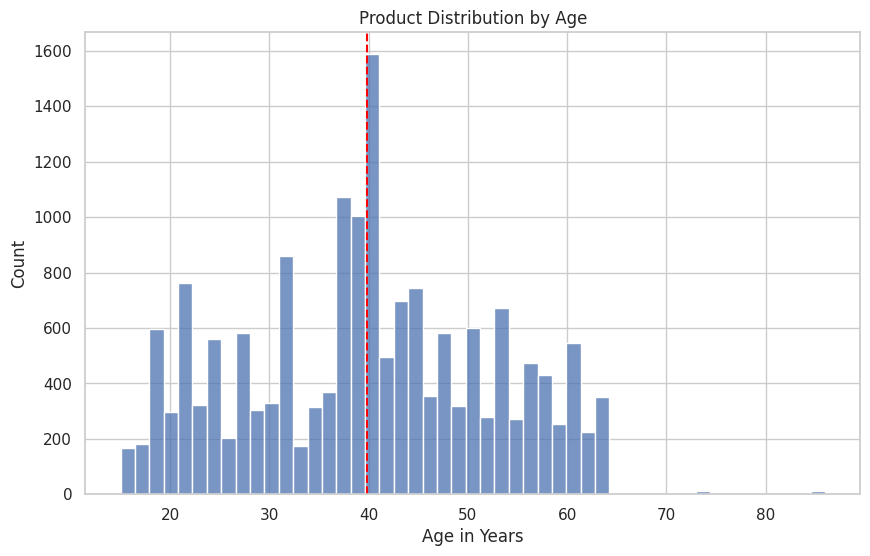

Mean:  39.858654128709965


In [39]:
# Product Distribution by age

import matplotlib.pyplot as plt
import seaborn as sns

# Convert customer_age to int64 instead of Int64
master_null['customer_age'] = master_null['customer_age'].astype('int64')

sns.set_style('whitegrid')

plt.figure(figsize=(10, 6))
sns.histplot(data=master_null, x='customer_age')
plt.title('Product Distribution by Age')
plt.xlabel('Age in Years')
plt.ylabel('Count')
plt.axvline(master_null['customer_age'].mean(), color='red', linestyle='--', label='Mean')
plt.show()

print('Mean: ', master_null['customer_age'].mean())

I recieved a peculiar error with the same code when I tried to use Int64 instead of int64, turns out some seaborne functions can not handle non nullable data types.

- 'Int64': 'Int64' is a nullable integer data type introduced in pandas 0.24.0. It allows for the representation of integer data with the presence of NaN values. This means that if you have missing values (NaN) in your integer column, pandas will use the 'Int64' data type to indicate that it supports nullable integers.

- 'int64': 'int64' (lowercase 'i') is the regular integer data type (non-nullable) provided by NumPy, which is the underlying library used by pandas. In 'int64' data type, there are no NaN values allowed, and the data is treated as non-nullable integers.

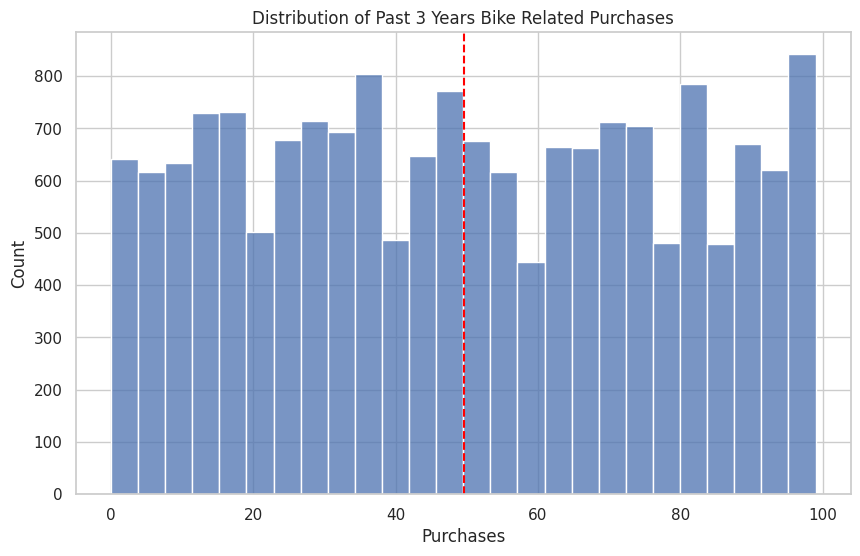

Mean:  49.55838965618572


In [40]:
# Product Distribution by age

import matplotlib.pyplot as plt
import seaborn as sns

# Convert customer_age to int64 instead of Int64
master_null['past_3_years_bike_related_purchases'] = master_null['past_3_years_bike_related_purchases'].astype('int64')

sns.set_style('whitegrid')

plt.figure(figsize=(10, 6))
sns.histplot(data=master_null, x='past_3_years_bike_related_purchases')
plt.title('Distribution of Past 3 Years Bike Related Purchases')
plt.xlabel('Purchases')
plt.ylabel('Count')
plt.axvline(master_null['past_3_years_bike_related_purchases'].mean(), color='red', linestyle='--', label='Mean')
plt.show()

print('Mean: ', master_null['past_3_years_bike_related_purchases'].mean())

age_group
31-50    52.365560
14-30    25.312959
51-70    22.162798
71-90     0.158684
Name: proportion, dtype: float64


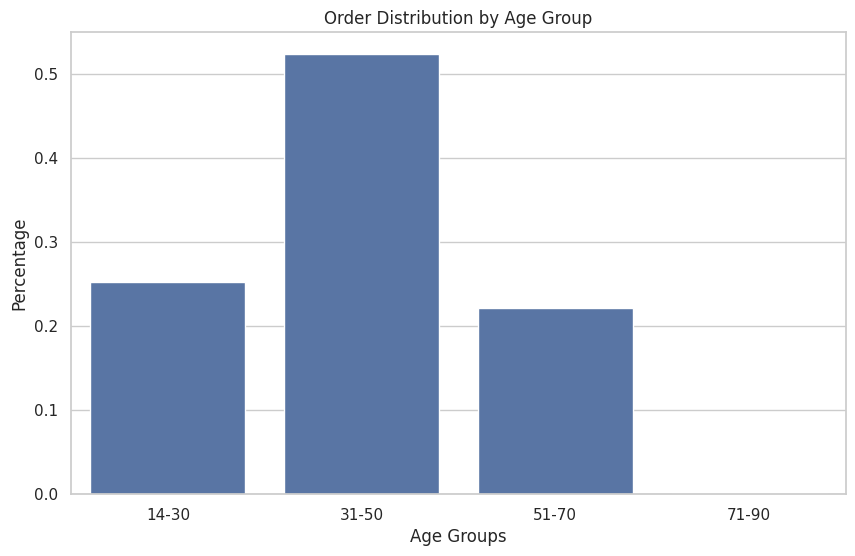

In [41]:
# Order Distribution by Age Group

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
base_color = sns.color_palette()[0]

counts = master_null['age_group'].value_counts(normalize=True)
sns.barplot(x= counts.index, y=counts.values, color=base_color)
plt.xlabel('Age Groups')
plt.ylabel('Percentage')
print(counts * 100)

plt.title('Order Distribution by Age Group')
plt.show()



Seems like the age groups 31-50 gets the most percentage of orders, and turns out they also bring in the most profits.

  age_group      profit
0     14-30  2395823.95
1     31-50  4905796.82
2     51-70  2086676.67
3     71-90    15576.84


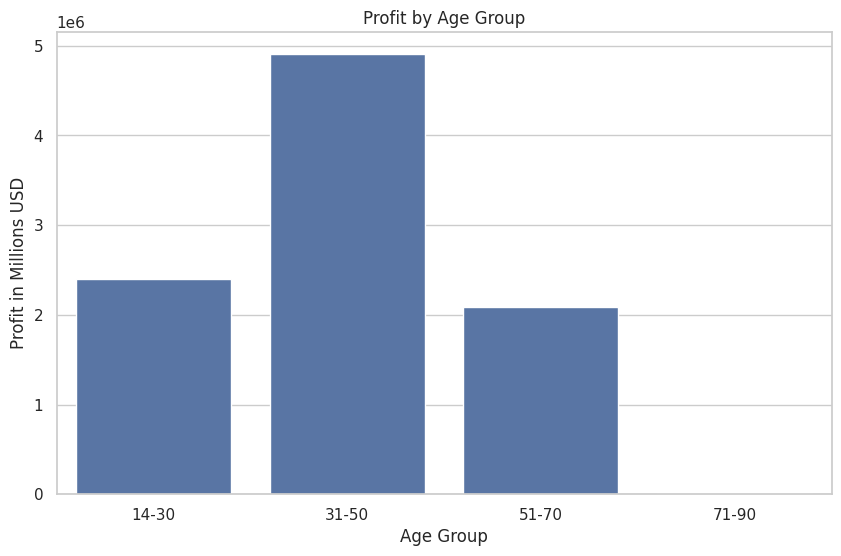

In [42]:
# Profit Distribution by Age Group

import matplotlib.pyplot as plt 
import seaborn as sns

plt.figure(figsize=(10, 6))
base_color = sns.color_palette()[0]
profit_by_age = master_null.groupby('age_group')['profit'].sum().reset_index()
sns.barplot(x='age_group', y='profit', data=profit_by_age, color=base_color)

# Set labels and title
plt.xlabel('Age Group')
plt.ylabel('Profit in Millions USD')
plt.title('Profit by Age Group')

print(profit_by_age.head())

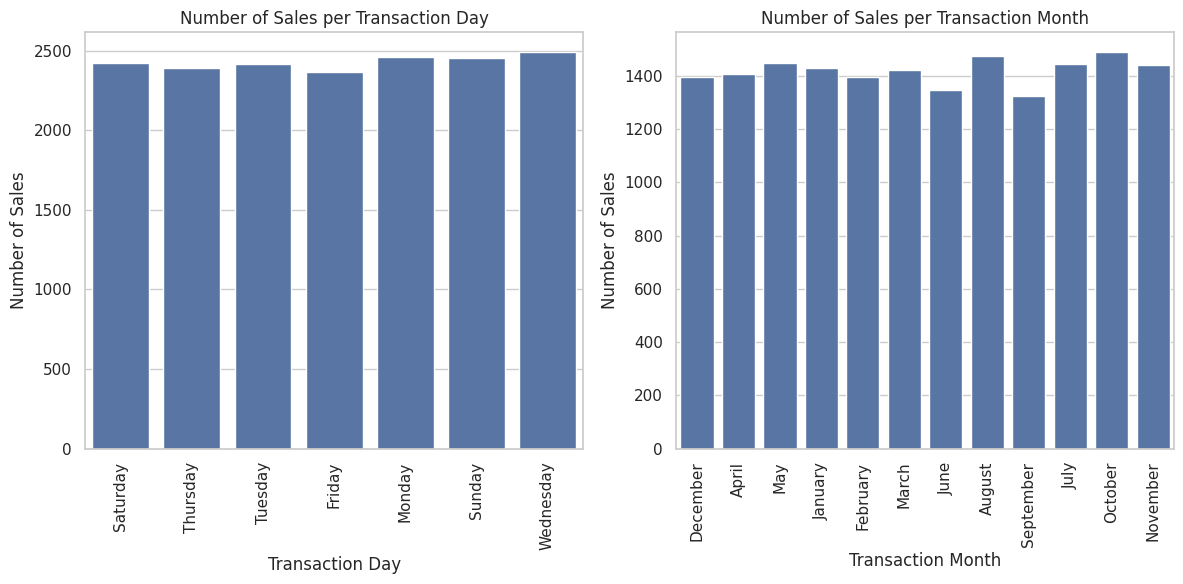

In [43]:
# Set the size of the figure
plt.figure(figsize=(12, 6))

# Bar plot for transaction day
plt.subplot(1, 2, 1)  # Subplot 1
sns.countplot(data=master_null, x='transaction_day', color=base_color)
plt.title('Number of Sales per Transaction Day')
plt.xticks(rotation=90)
plt.xlabel('Transaction Day')
plt.ylabel('Number of Sales')

# Bar plot for transaction month
plt.subplot(1, 2, 2)  # Subplot 2
sns.countplot(data=master_null, x='transaction_month', color=base_color)
plt.title('Number of Sales per Transaction Month')
plt.xlabel('Transaction Month')
plt.ylabel('Number of Sales')
plt.xticks(rotation=90)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


Turns out sales do not depend on the day of the week or the month really.

wealth_segment
Mass Customer        49.750220
High Net Worth       25.424625
Affluent Customer    24.825154
Name: proportion, dtype: float64


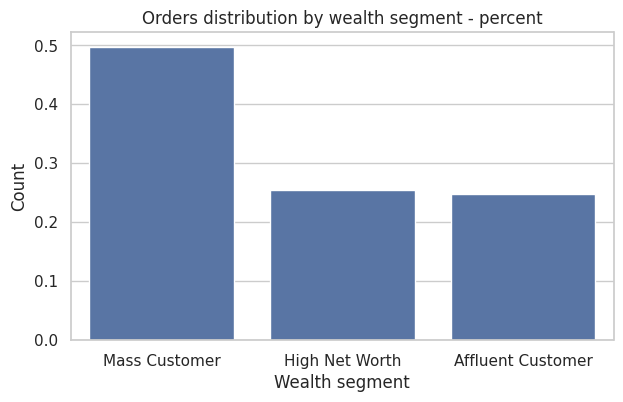

In [44]:
#Orders distribution by wealth segment
plt.figure(figsize = (7,4), dpi = 100)

counts = master_null['wealth_segment'].value_counts(normalize = True)
sns.barplot(x = counts.index, y = counts.values, color=base_color)
plt.xlabel('Wealth segment')
plt.ylabel('Count')
print(counts * 100)

plt.title("Orders distribution by wealth segment - percent")
plt.show()

state
NSW    53.294152
VIC    25.160153
QLD    21.545695
Name: proportion, dtype: float64


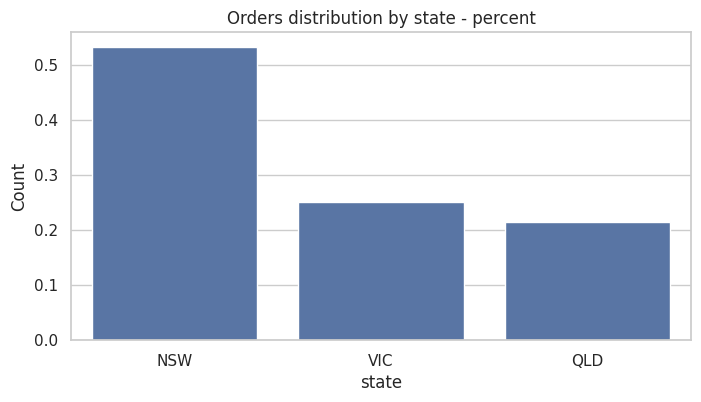

In [45]:
# Orders distribution by state
plt.figure(figsize = (8,4), dpi = 100)
counts = master_null['state'].value_counts(normalize = True)
sns.barplot(x = counts.index, y = counts.values, color=base_color)
plt.xlabel('state')
plt.ylabel('Count')
print(counts * 100)

plt.title("Orders distribution by state - percent")
plt.show()

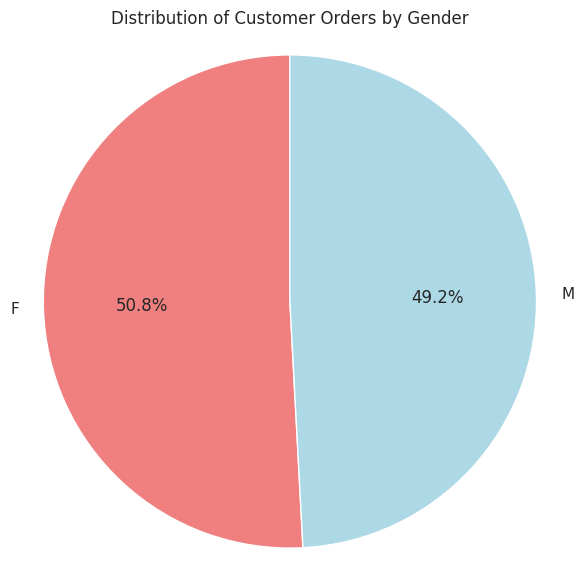

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7), dpi=100)

counts = master_null['gender'].value_counts(normalize=True)
labels = counts.index
sizes = counts.values
colors = ['lightcoral', 'lightblue']  # You can customize the colors here

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

plt.title("Distribution of Customer Orders by Gender")
plt.show()


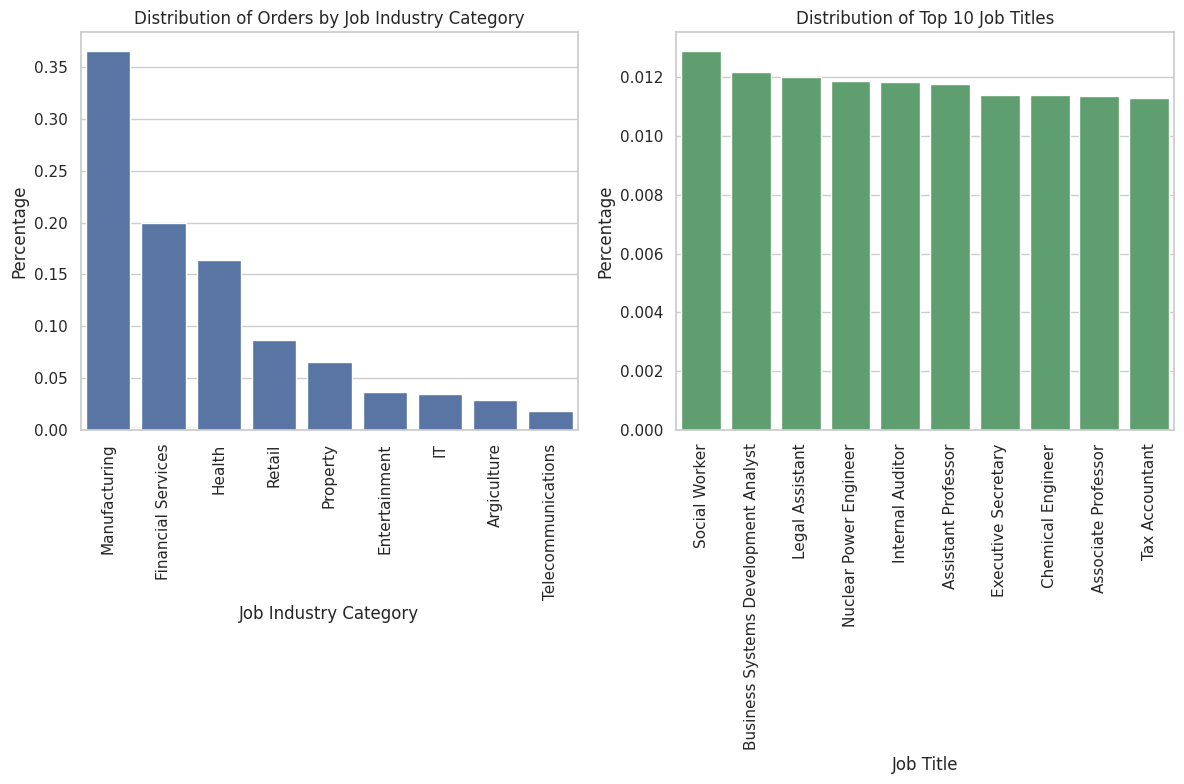

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(12, 8))

# Plotting the distribution of orders by job industry category
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
counts_industry = master_null['job_industry_category'].value_counts(normalize=True)
sns.barplot(x=counts_industry.index, y=counts_industry.values, color='b')
plt.xlabel('Job Industry Category')
plt.ylabel('Percentage')
plt.xticks(rotation=90)  # Rotate x-axis labels to 90 degrees
plt.title("Distribution of Orders by Job Industry Category")

# Plotting the distribution of top 10 job titles
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
top_10_titles = master_null['job_title'].value_counts(normalize=True).head(10)
sns.barplot(x=top_10_titles.index, y=top_10_titles.values, color='g')
plt.xlabel('Job Title')
plt.ylabel('Percentage')
plt.xticks(rotation=90)  # Rotate x-axis labels to 90 degrees
plt.title("Distribution of Top 10 Job Titles")

plt.tight_layout()  # To prevent overlapping labels and titles
plt.show()


### Highlights of Univariate Analysis
- From the Price Distribution, it's clear that it is a normally distributed data with no outliers, and a mean of **1110 USD**
- The Profit Distribution is Right Skewed, with a mean of **550 USD**
- The Age is Distributed between 20 and 60, with most of the customers being around the age of 30 and 45, makes sense for them to invest in a bicycle.
- The Past 3 Year Bicycle purchase is also normally distributed, with a mean of **49 Purchases**
- The Age Segment that buys the most is **31-50**, they also bring out hte most profit
- Most Purchases have been made on Mondays and Wednesdays, of course buying a bicycle will be the least of my concerns on a weekend.
- August and October are the months with the most sales,
- Most of the sales are made to the **Mass Customer** segment, accounting for **50%** of the sales.
- Most of the sales are made in the NSW region, accounting for **50%** of the sales.
- Women seem to be getting more sales by just a percent
- The industry to be targeted is **Manufacturing**, then **Financial Services** and **Health**

## Bivariate Analysis
In this section we will investigate the pair of variables and their relationship between each other.

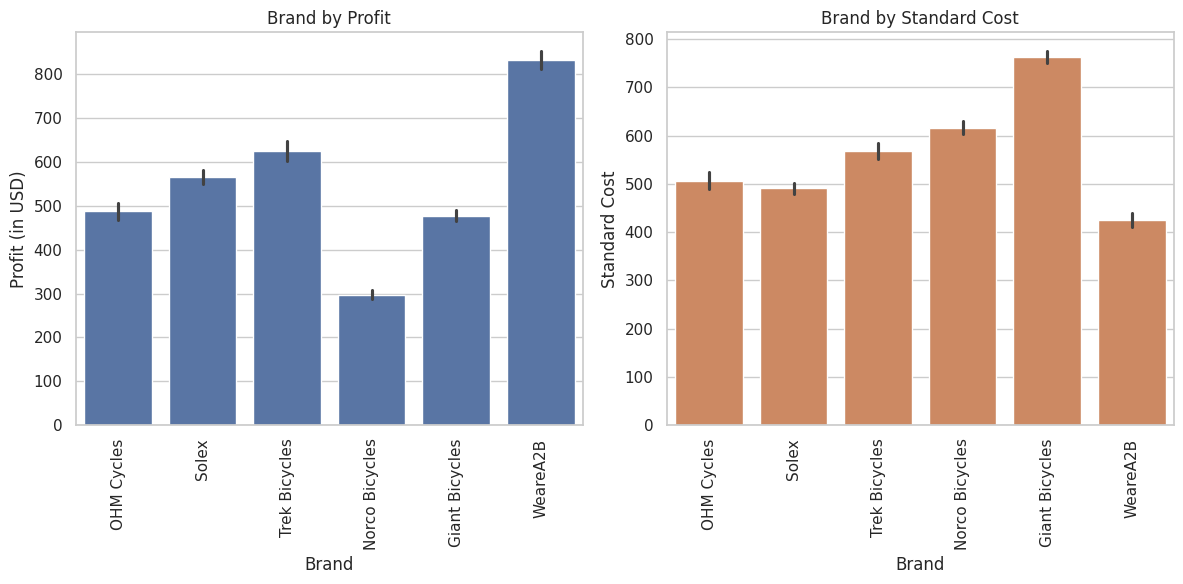

In [48]:
# Brand by Profit and Standard Cost

import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(12, 6))

# First subplot - Profit by Brand
plt.subplot(1, 2, 1)
sns.barplot(data=master_null, x="brand", y='profit', color=sns.color_palette()[0])
plt.xlabel('Brand')
plt.ylabel('Profit (in USD)')
plt.xticks(rotation=90)
plt.title("Brand by Profit")

# Second subplot - Standard Cost by Brand
plt.subplot(1, 2, 2)
sns.barplot(data=master_null, x="brand", y='standard_cost', color=sns.color_palette()[1])
plt.xlabel('Brand')
plt.ylabel('Standard Cost')
plt.xticks(rotation=90)
plt.title("Brand by Standard Cost")

plt.tight_layout()
plt.show()


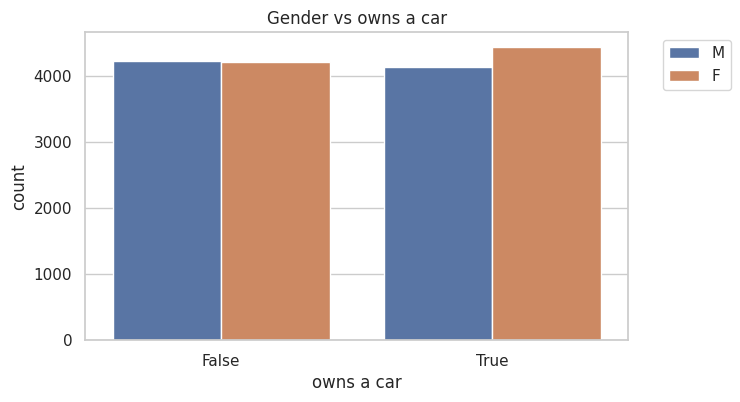

In [49]:
#Gender vs owns a car

plt.figure(figsize = (7,4), dpi = 100)

sns.countplot(data = master_null, x = "owns_car",hue='gender')
plt.xlabel('owns a car');
plt.ylabel('count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Gender vs owns a car")

plt.show()

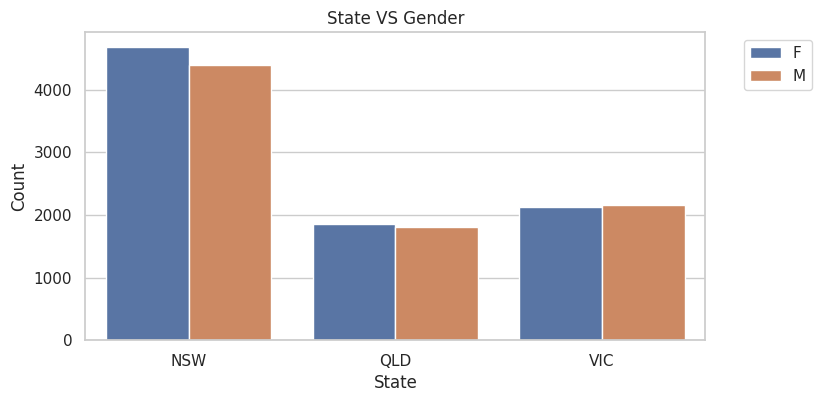

In [50]:
#State vs Gender

plt.figure(figsize = (8,4), dpi = 100)

sns.countplot(data = master_null, x = "state",hue='gender')
plt.xlabel('State');
plt.ylabel('Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("State VS Gender")

plt.show()

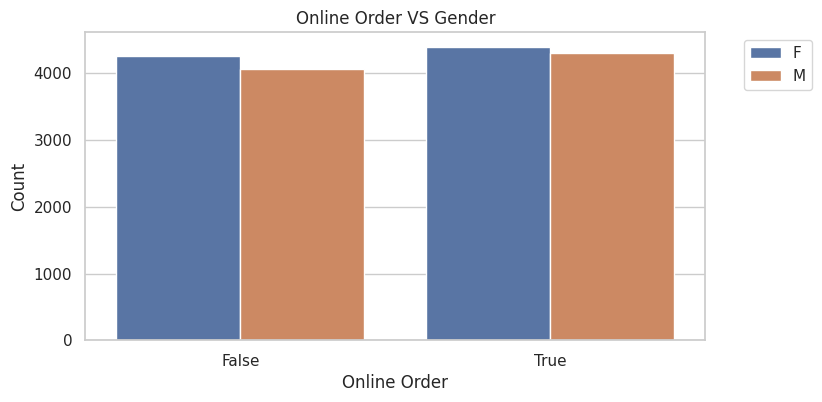

In [51]:
#State vs Gender

plt.figure(figsize = (8,4), dpi = 100)

sns.countplot(data = master_null, x = "online_order",hue='gender')
plt.xlabel('Online Order');
plt.ylabel('Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Online Order VS Gender")

plt.show()

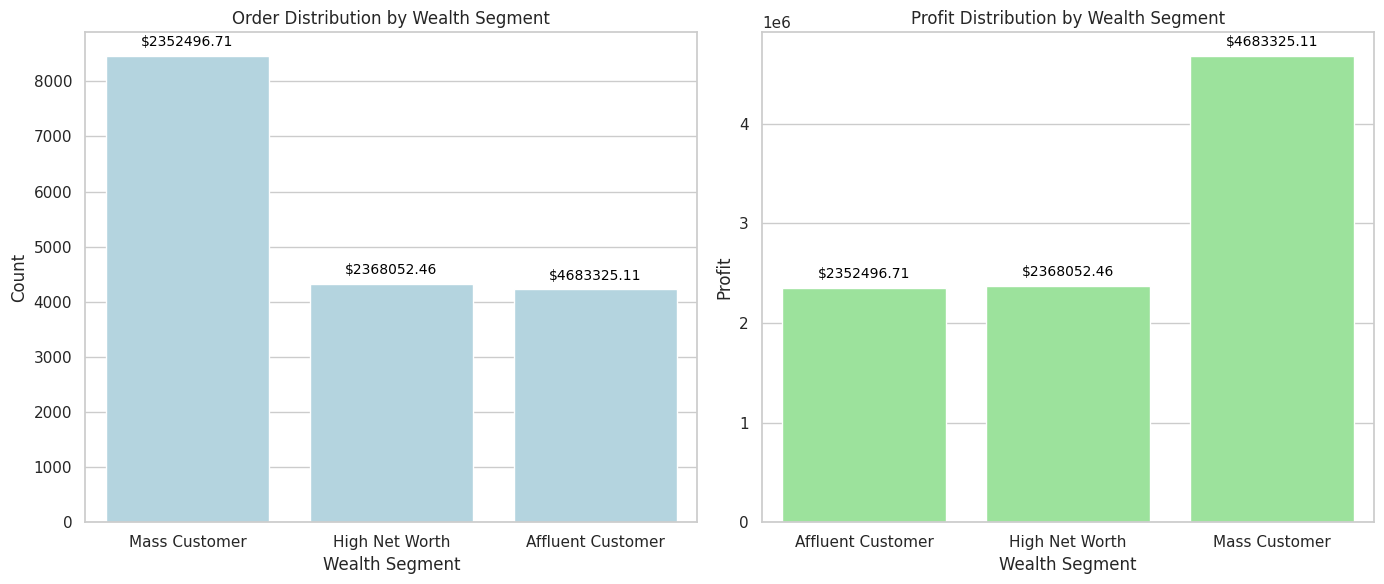

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=100)

# Calculate the order count and profit per wealth segment
counts = master_null['wealth_segment'].value_counts()
profits = master_null.groupby('wealth_segment')['profit'].sum()

# Normalize the counts to percentages
counts_percent = (counts / counts.sum()) * 100

# Create a bar plot for order distribution
sns.barplot(x=counts_percent.index, y=counts.values, color='lightblue', ax=ax1)
ax1.set_xlabel('Wealth Segment')
ax1.set_ylabel('Count')
ax1.set_title("Order Distribution by Wealth Segment")

# Add profit labels to the bars in the order distribution plot
for i, p in enumerate(ax1.patches):
    ax1.annotate(f'${profits[i]:.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
                textcoords='offset points')

# Create a bar plot for profit distribution
sns.barplot(x=profits.index, y=profits.values, color='lightgreen', ax=ax2)
ax2.set_xlabel('Wealth Segment')
ax2.set_ylabel('Profit')
ax2.set_title("Profit Distribution by Wealth Segment")

# Add profit labels to the bars in the profit distribution plot
for i, p in enumerate(ax2.patches):
    ax2.annotate(f'${profits[i]:.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
                textcoords='offset points')

# Adjust spacing between subplots
plt.tight_layout()

plt.show()


Some of the conclusions derieved from the analysis are:
- More of women who own a car buy bikes, and more of men who do not own a car buy bikes
- NSW has the highest number of bike buyers and more Female buyers than male buyers
- More women buy bikes online than men
- Most profitable brand is WeareA2B

## Multivariate Analysis


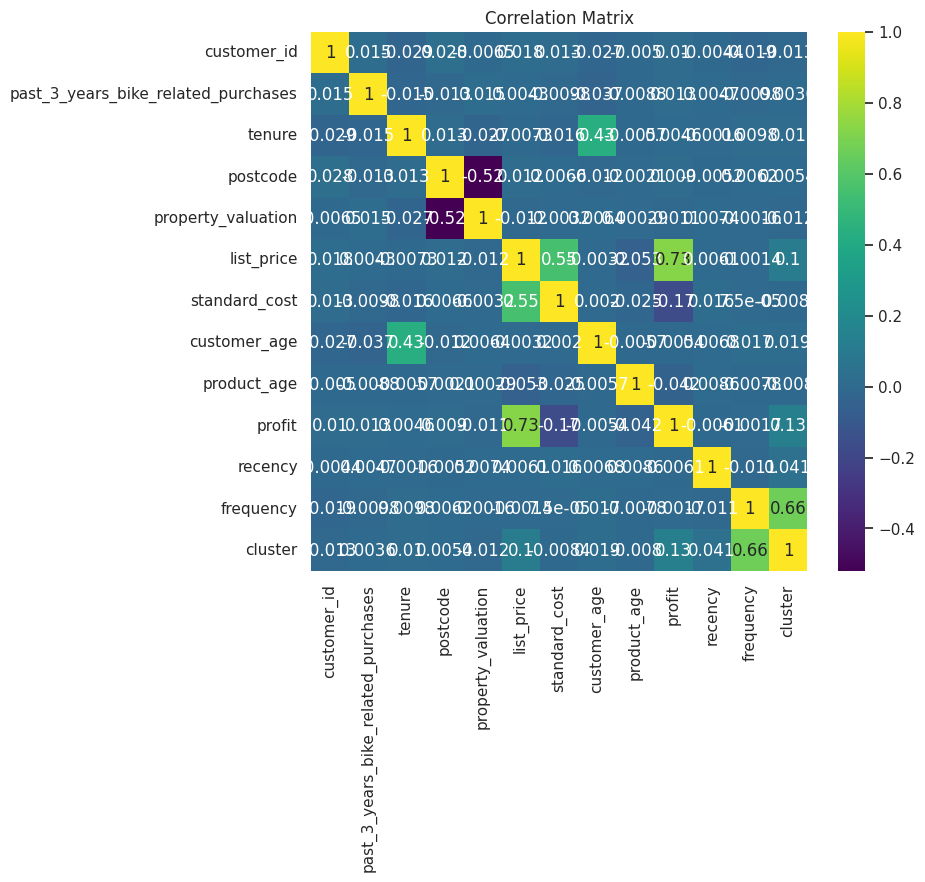

In [53]:
# Drop non-numeric columns or encode them properly
numeric_columns = master_null.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()

# Create the correlation matrix heatmap
plt.figure(figsize=(8,7), dpi=100)
sns.heatmap(correlation_matrix, cmap="viridis", annot=True)
plt.title("Correlation Matrix")
plt.xticks(rotation=90)
plt.show()

Seems like there isnt a strong correlation between the variables, the ones that are related are of course the one's we have engineered.

## Objectives Fulfilled
- Data Quality Assessment
- Data Insights
- RFM Analysis
- Customer Segmentation
- Finalised Sheet

> In the next Task we will be building a Machine Learning Model to predict the future customers.
> 
> The current task also deals with making a powerpoint presentation for the client, to get a signoff.

In [54]:
master_null.to_csv('reference.csv', index=False)
analyze_null_values(master_null)

Null Values  Total Values  \
customer_id                                    0         17015   
gender                                         0         17015   
cluster                                        0         17015   
frequency                                      0         17015   
recency                                        0         17015   
age_group                                      0         17015   
transaction_month                              0         17015   
transaction_day                                0         17015   
profit                                         0         17015   
product_age                                    0         17015   
customer_age                                   0         17015   
product_first_sold_date                        0         17015   
standard_cost                                  0         17015   
list_price                                     0         17015   
product_size                                   0         17015   
product_class                                  0         17015   
product_line                                   0         17015   
brand                                          0         17015   
order_status                                   0         17015   
online_order                                   0         17015   
transaction_date                               0         17015   
property_valuation                             0         17015   
state                                          0         17015   
postcode                                       0         17015   
tenure                                         0         17015   
owns_car                                       0         17015   
wealth_segment                                 0         17015   
job_industry_category                          0         17015   
job_title                                      0         17015   
DOB                                            0         17015   
past_3_years_bike_related_purchases            0         17015   
customer_category                              0         17015   

                                     Percentage of Missing Values  
customer_id                                                   0.0  
gender                                                        0.0  
cluster                                                       0.0  
frequency                                                     0.0  
recency                                                       0.0  
age_group                                                     0.0  
transaction_month                                             0.0  
transaction_day                                               0.0  
profit                                                        0.0  
product_age                                                   0.0  
customer_age                                                  0.0  
product_first_sold_date                                       0.0  
standard_cost                                                 0.0  
list_price                                                    0.0  
product_size                                                  0.0  
product_class                                                 0.0  
product_line                                                  0.0  
brand                                                         0.0  
order_status                                                  0.0  
online_order                                                  0.0  
transaction_date                                              0.0  
property_valuation                                            0.0  
state                                                         0.0  
postcode                                                      0.0  
tenure                                                        0.0  
owns_car                                                      0.0  
wealth_segment        